# Selecting the number of topics

This notebook selects *k,* the number of topics in our model, using the ground truth of human categorization as a guide.

Researchers have tried a number of different schemes for selecting the optimal number of topics in a model. [Wallach et al. (2009)](http://dirichlet.net/pdf/wallach09evaluation.pdf) proposed using the model to make predictions on held-out documents. A few years later, [Mimno et al. (2013)](http://dirichlet.net/pdf/mimno11optimizing.pdf) introduced semantic coherence measures as a different strategy.

Today, both of these strategies are still in use, but a variety of other measures are also commonly deployed to optimize *k*.

There is no settled best practice, of course, because the algorithms for topic modeling don't in themselves imply a criterion for deciding between models with different numbers of topics.

In the empirical experience of researchers, models with different numbers of topics are often equally effective as dimension-reductions of a corpus. Researchers use dimension-reduction methods pragmatically, to simplify a problem space, and the operation doesn't necessarily depend on the premise that there is any optimal number of dimensions. If topic modeling produces a representation of a corpus that is valid at all for a particular research question, it ought to be broadly valid for a range of different settings of *k*.

Pressure to define a "reasonable" value of *k* comes mostly from the practice of attaching interpretive labels to individual topics. When topics are interpreted individually, it can seem problematic that two topics discussed separately at *k* = 200 might have been (partly) fused if the researcher had selected *k* = 100. Both models may be equally valid, mathematically. But it seems fair to ask researchers to justify the level of granularity they have chosen to discuss.

To produce these justifications, however, researchers always have to import some assumptions about the desirable qualities of a model that weren't present in the topic-modeling algorithm itself. The commonly-used metric of "exclusiveness," for instance, implies an assumption that the keywords in different topics should be non-overlapping. This is basically an assumption about the qualities a model should possess in order to be easily interpreted by a human reader. (And for what it's worth, Mimno et al. are able to validate this assumption against human judgement.)

In this project, we want to produce a model that will roughly echo the level of granularity human readers are accustomed to when they discuss literary movements, themes, and genres. When we draw inferences about literary change, we hope to ensure that these inferences are valid *for that familiar level of granularity,*—and not only on some unfamiliar macroscopic or microscopic scale.

The simplest way to ensure this would be to validate our choice of *k* against some ground truth reflecting actual human practice when it comes to the categorization of fiction.

Fortunately, we have a lot of ground truth to use. Shang and Underwood have parsed large amounts of [the index to the *Book Review Digest*,](https://babel.hathitrust.org/cgi/pt?id=uiug.30112097123480&view=1up&seq=572) which records subject and genre categories applied to works of fiction soon after they were published, from the 1920s to the present. In addition, we can use Library of Congress categories recorded in library metadata from the 1980s and 1990s. 

Putting these together, we constructed a set of 256 volumes that were present in our topic model and also grouped by human readers into 30 different categories of varying sizes. We used a variety of different metrics to compare the human partitioning of this set to the partitionings created by a topic model. We do not assume that the human categories are correct, or that they exhaustively cover the domain space, or in fact that they represent any kind of "ground truth" about fiction. Our goal is not to produce a model that would perfectly align with human judgment. (If a researcher wanted to do that, they would use a supervised method rather than topic modeling.) On the contrary, we are fairly confident that a topic model will identify many interesting historical clusters that a human cataloger might have overlooked.

We are merely selecting a *level of granularity* for the model. It seems reasonable to do that by finding a setting where *some* categories in the model align well with *some* human concepts. Since we are only adjusting a single hyperparameter, it would be hard for this process to overfit the model.

The cells below try two different measurement schemes: one that discretizes the topic model, and one that allows it to remain a fuzzy partitioning. The notebook ends by combining them.

In [1]:
import pandas as pd
import random
import seaborn as sns
import numpy as np
from matplotlib import pyplot as plt
%matplotlib inline
from scipy.spatial.distance import cosine
from sklearn.metrics import adjusted_rand_score
from sklearn.metrics import adjusted_mutual_info_score

### Import human partitions

We start by reading a data frame with document IDs and headings assigned by human readers.

In [2]:
human = pd.read_csv('human_labels.tsv', sep = '\t')
human.sample(10)

,docid,hathi_author,hathi_title,firstpub,pubdate_known,heading
173,mdp.39015073495619,"Townsend, Larry",The sexual adventures of Sherlock Holmes,1993,False,post1980mystery
11,uc1.$b300921,"Hooke, Nina Warner",Striplings,1932,True,"Children, Stories about"
193,mdp.39015034258619,"McDevitt, Jack",The engines of God,1994,True,post1980sSF
248,mdp.39015063945649,"Parker, Maude",Impersonation of a lady,1934,True,Small-town life
8,mdp.39015011884213,"Sinclair, Upton",Wide is the gate,1943,True,Character studies
31,mdp.39015024524640,"Wells, H. G. (Herbert George)",The croquet player,1936,True,Fantasies
132,mdp.39015049845632,"Keeler, Harry Stephen",The riddle of the traveling skull,1934,True,Mystery and detective stories
235,uc1.32106014501446,"Stead, Christina",The Salzburg tales,1934,True,Short stories
233,uc1.$b803090,"Miller, Alice Duer, Mrs",Come out of the pantry,1933,True,Short stories
19,uc1.$b105474,"Stong, Phil",The rebellion of Lennie Barlow,1937,True,Education


As you can see above, there are some fairly large categories, like "Mystery and detective stories" — which occurs twice — as well as smaller ones like "Romance" or "Locality, England." We do make some editorial decisions here; for instance, the *Book Review Digest* often categorizes novels by their setting in individual states of the US. We lump those categories as "Locality, US," because we don't think our corpus will be big enough to trace the literary history of Idaho.

Mystery stories from the 1980s and 90s are separated from ones from the 30s and 40s. We do want to find a level of granularity that acknowledges the possibility of historical change.

## A simple metric: adjusted mutual information on two hard partitionings.

Adjusted mutual information is a commonly-used way to compare two partitioning schemes.

It requires us to transform the topic model into a hard partitioning (where each book belongs to one and only one category). But this might arguably be desirable, since we're selecting a level of granularity. A fuzzy partitioning could conceivably approximate a hard one without adopting the same level of granularity.

The first function below reads the document-topic matrix produced by Mallet. The second function discretizes that matrix by assigning each document to its most prominent topic, and then measures adjusted mutual information between the model partitioning and the human partitioning.

To get a sense of variation, we do jackknife resampling, masking one human category at a time.

In [3]:
def get_doctopics(filename, docsequence):
    chunks = dict()
    with open(filename, encoding = 'utf-8') as f:
        for line in f:
            fields = line.strip().split()
            chunkid = fields[1]
            docid = fields[1].split('_')[0]
            if docid not in docsequence:
                continue
            if docid not in chunks:
                chunks[docid] = []
            vector = np.array([float(x) for x in fields[2: ]])
            chunks[docid].append(vector)
            
    docs = dict()   
    for docid, value in chunks.items():
        avgvector = np.mean(value, axis = 0)
        docs[docid] = avgvector
    
    return docs


def discrete_mi(doctopic_file):
    
    global human
    
    collabels = list(human.heading.unique())
    humanseq = []
    for idx, row in human.iterrows():
        headingposition = collabels.index(row.heading)
        humanseq.append(headingposition)
    
    docsequence = human.docid.tolist() 
    docs = get_doctopics(doctopic_file, docsequence)
    
    topicseq = []
    for d in docsequence:
        vector = list(docs[d])
        maxtopic = vector.index(max(vector))
        topicseq.append(maxtopic)
    
    df = pd.DataFrame({'human': humanseq, 'topic': topicseq})
    allhumtopics = set(humanseq)
    amis = []
    
    for tomask in allhumtopics:
        # tomask = random.sample(allhumtopics, 1)[0]
        dfsample = df.loc[df.human != tomask, : ]
        ami = adjusted_mutual_info_score(dfsample.human, dfsample.topic)
        amis.append(ami)
    
    return amis

We use Mallet to generate topic models with a range of different *k*s, and measure adjusted mutual information for each.

(The batch scripts used to create the models are available in the repo.)

In [4]:
# RUNNING ADJUSTED MUTUAL INFORMATION ON A RANGE OF MODELS

ks = []
ami = []
meanami = []
for i in [25, 50, 100, 150, 200, 250, 300, 350, 400, 500, 600]:
    results = discrete_mi('k' + str(i) + 'doctopics.txt')
    
    res = np.mean(results)
    ks.extend([i] * len(results))
    ami.extend(list(results))
    
    print(i, round(res, 4))
    meanami.append(round(res, 4))

25 0.1818
50 0.2284
100 0.2544
150 0.2633
200 0.2388
250 0.2244
300 0.2427
350 0.2
400 0.2273
500 0.1703
600 0.1237


The mean AMI rises to *k* = 150, and declines slowly as the value of *k* increases further. Note, however, that there's a lot of variation produced by resampling. Our confidence about details should be fairly low, and any value of k between 50 and 400 might be defensible. There's nothing obviously wrong about seeking a level of granularity *slightly* more, or less, detailed than the typical level in human reference books and library catalogs (which is itself variable).

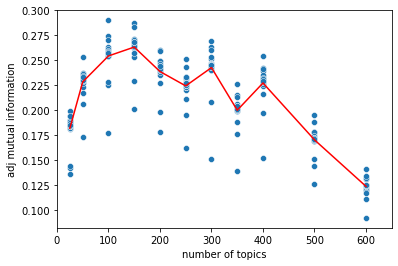

In [5]:
sns.lineplot(x = [25, 50, 100, 150, 200, 250, 300, 350, 400, 500, 600], y = meanami, color = 'red')
sns.scatterplot(x = ks, y = ami)
plt.ylabel('adj mutual information')
plt.xlabel('number of topics')
plt.xlim(0, 650)
plt.show()

But there is something slightly unsatisfying about discretizing the topic model. In doing that, we discard much of the information it provides about any given book.

There are also ways to compare a fuzzy partition to a discrete one. For instance, [Brouwer (2009)](https://link.springer.com/article/10.1007/s10844-008-0054-7) defines an extension of the adjusted Rand index for fuzzy partitions. This is implemented below. For the definition of a "bounding matrix" see Brouwer's article.

In [6]:
def make_bounding_matrix(docs, docsequence):
    n = len(docsequence)
    bmatrix = np.array([np.zeros(n)] * n)
    for idx1, d1 in enumerate(docsequence):
        for idx2, d2 in enumerate(docsequence):
            cos = cosine(docs[d1], docs[d2])
            bmatrix[idx1, idx2] = cos
    return bmatrix

def human_bmatrix():
    
    '''Returns the human groundtruth bounding matrix, plus a fixed
    sequence of docids that will organize both matrices.'''
    global human
    collabels = list(human.heading.unique())
    docs = dict()
    for idx, row in human.iterrows():
        vector = np.zeros(len(collabels))
        idx = collabels.index(row.heading)
        vector[idx] = 1
        docs[row.docid] = vector
    
    bmatrix = make_bounding_matrix(docs, human.docid.tolist())
    return bmatrix, human.docid.tolist()
        
def compare_human_and_topicmodel(doctopic_file):
    human_matrix, docsequence = human_bmatrix()
    docs = get_doctopics(doctopic_file, docsequence)
    topic_matrix = make_bounding_matrix(docs, docsequence)
    
    n = len(docsequence)
    
    a = (np.multiply(human_matrix, topic_matrix).sum() / 2) -  (n / 2)
    b = np.multiply(1 - human_matrix, topic_matrix).sum() / 2
    c = np.multiply(human_matrix, 1 - topic_matrix).sum() / 2
    d = np.multiply(1 - human_matrix, 1- topic_matrix).sum() / 2
            
    ari = (2 * ((a * d) - (b * c))) / ((c ** 2) + (b ** 2) + (2 * a * d) + (a + d) * (c + b))
    
    return ari
        
        

In the code below we apply Brouwer's metric to all of our models.

In [7]:
ks = []
ari = []
for i in [25, 50, 100, 150, 200, 250, 300, 350, 400, 500, 600]:
    result = compare_human_and_topicmodel('k' + str(i) + 'doctopics.txt')
    
    ks.append(i)
    ari.append(result)
    
    print(i, round(result, 4))

25 0.054
50 0.0714
100 0.0772
150 0.0859
200 0.0892
250 0.1145
300 0.1006
350 0.1176
400 0.099
500 0.1087
600 0.1113


<AxesSubplot:>

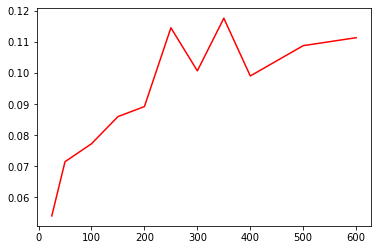

In [8]:
sns.lineplot(x = [25, 50, 100, 150, 200, 250, 300, 350, 400, 500, 600], y = ari, color = 'red')

On this view of the problem, the fit between topic models and human classification rises to about k = 250, and then levels off. (It's not clear whether changes after that point are very significant.)

This metric may not be steering us quite as reliably as the hard partitioning did: for instance, in practice, a model with 600 topics would have a lot of tiny categories that are difficult to interpret or highly specific to a single author.

But the graph above does reflect the reality that something is gained by making a model more fine-grained. Typically, a fine-grained model can capture more information.

We could also combine the two metrics and consider what would happen if we tried to optimize both at once.

We build a dataframe that has both metrics for each model.

In [9]:
df = pd.DataFrame({'fuzzy_ari': ari, 'AMI': meanami, 
                   'labels': [str(x) for x in [25, 50, 100, 150, 200, 250, 300, 350, 400, 500, 600]]})

Then we can visualize the discrete metric on the vertical axis, and the fuzzy metric on the horizontal axis. We label each model with the number of topics.

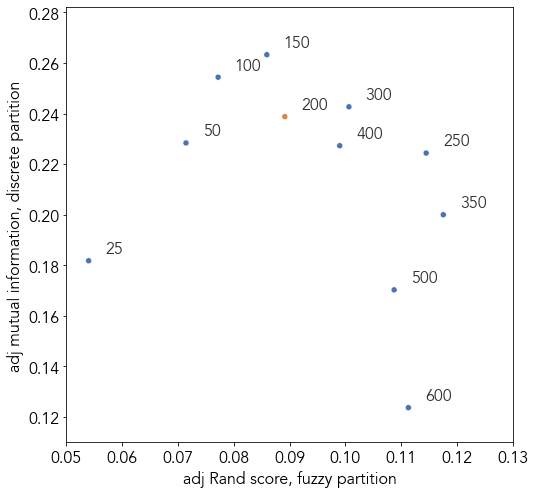

In [17]:
plt.figure(figsize = (8, 8))
ax = sns.scatterplot(data = df, x = 'fuzzy_ari', y = 'AMI', legend = False,
                     hue = [1,1,1,1,2,1,1,1,1,1,1], palette = 'deep')
for idx, row in df.iterrows():
    ax.text(y = row['AMI'] + .003, x = row['fuzzy_ari'] + .003, 
            s = row['labels'], alpha = 0.8)

plt.xlabel('adj Rand score, fuzzy partition')
plt.ylabel('adj mutual information, discrete partition')
plt.xlim(0.05, 0.13)
plt.ylim(0.11, 0.282)

plt.rcParams.update({'font.sans-serif':'Avenir'})
plt.rcParams.update({'font.size': 16})
plt.gcf().set_facecolor('white')
plt.savefig('/Users/tunder/Dropbox/python/cohort/figures/SIoptimizeK.png', bbox_inches = 'tight', dpi = 300)

To evaluate this picture, remember that we're trying to maximize both axes —— or in other words, trying to move to the upper right corner.

If that's the goal, it appears that a variety of choices between 100 and 400 topics are almost equally defensible, depending on the exact balance of precision and generality desired in a particular inquiry.

The picture does, however, help us rule out extreme options like 25 topics, or 600. Those models might be quantitatively valid. But they will probably not be good approximations of the scale of categorization that human readers normally apply to fiction.

(These results will not surprise people who have done a lot of topic modeling; they roughly align with the rule of thumb recommended, for instance, by [the designers of Mallet:](http://mallet.cs.umass.edu/topics.php) "The number of topics should depend to some degree on the size of the collection, but 200 to 400 will produce reasonably fine-grained results.")

In our inquiry, we selected a model with 200 topics, which appeared to give a good balance between both of the metrics considered here. There were also other interpretive advantages to a relatively low setting of *k*, since increasing the number of topics might produce author-specific topics that would appear a bit circular for our research question. While there are methods of subtracting the author-specific signature [(Thompson and Mimno 2018),](https://www.cs.cornell.edu/~laurejt/papers/authorless-tms-2018.pdf) that would also introduce a problematic kind of bias for the question we're investigating—-which is exactly about the stability or mutability of authorial style.